# Sampling and Testing the Penguins

This notebook uses the [Palmer Penguins data](https://github.com/allisonhorst/palmerpenguins) to demonstrate confidence intervals and two-sample hypothesis tests, both using parametric methods and the bootstrap.

Our question:  What are the average values of various penguin dimensions (bill length and depth, flipper length, and body mass)? Do these dimensions differ between penguin species?

## Setup

Python modules:

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sps
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

Set up a random number generator:

In [2]:
rng = np.random.default_rng(20200913)

Load the Penguin data:

In [3]:
penguins = pd.read_csv('../penguins.csv')
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


Some of these names are cumbersome to deal with. I'm going to give them shorter names:

In [4]:
penguins.rename(columns={
    'bill_length_mm': 'BillLength',
    'bill_depth_mm': 'BillDepth',
    'flipper_length_mm': 'FlipperLength',
    'body_mass_g': 'Mass'
}, inplace=True)

A few things will be eaiser if we also split out penguins by species:

In [5]:
chinstraps = penguins[penguins['species'] == 'Chinstrap']
chinstraps.head()

,species,island,BillLength,BillDepth,FlipperLength,Mass,sex,year
276,Chinstrap,Dream,46.5,17.9,192.0,3500.0,female,2007
277,Chinstrap,Dream,50.0,19.5,196.0,3900.0,male,2007
278,Chinstrap,Dream,51.3,19.2,193.0,3650.0,male,2007
279,Chinstrap,Dream,45.4,18.7,188.0,3525.0,female,2007
280,Chinstrap,Dream,52.7,19.8,197.0,3725.0,male,2007


In [6]:
adelies = penguins[penguins['species'] == 'Adelie']
gentoos = penguins[penguins['species'] == 'Gentoo']

That's all we need right now!

### Confidence Intervals

Remember that $s/\sqrt{n}$ is the **standard error** of the mean.  The SciPy [`sem`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.sem.html) function computes the standard error of the mean.  We can multiply this by 1.96 to get the distance between the sample mean and the edge of the confidence interval.

So let's write a function that returns the 95% CI of the mean of some data:

In [7]:
def mean_ci95(xs):
    mean = np.mean(xs)
    err = sps.sem(xs)
    width = 1.96 * err
    return mean - width, mean + width

## Warmup: Chinstrap Flippers

As a warmup, let's compute confidence intervals for the chinstrap flipper length.  We will do this with both the standard error and with the bootstrap.

Let's get the mean & SD of the Chinstrap penguins:

In [8]:
p_mean = chinstraps['FlipperLength'].mean()
p_std = chinstraps['FlipperLength'].std()  # defaults to sample SD
p_n = len(chinstraps)
p_mean, p_std, p_n

(195.8235294117647, 7.131894258578146, 68)

What's the confidence interval?

In [9]:
mean_ci95(chinstraps['FlipperLength'])

(194.12838574870136, 197.51867307482803)

Let's bootstrap the chinstraps, and compute the percentile 95% confidence interval for them:

In [10]:
boot_means = [np.mean(rng.choice(chinstraps['FlipperLength'], p_n)) for i in range(10000)]
np.quantile(boot_means, [0.025, 0.975])

array([194.14705882, 197.5       ])

And let's see the distribution of that bootstrap sample mean:

Text(0, 0.5, 'Density')

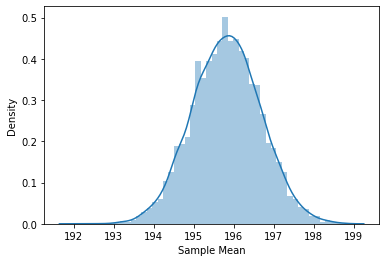

In [11]:
sns.distplot(boot_means)
plt.xlabel('Sample Mean')
plt.ylabel('Density')

## Penguin Statistics

With that warmup, let's look at our various biometrics.

### Parametric Estimates

We're going to compute CIs for several measurements, but we don't want to repeat all of our code.

Pandas `groupby` let us *apply* a function to each group, which can in turn return a series or a data frame.

Let's write a function that, given a series of penguin data, returns our statistics:

In [12]:
def mean_estimate(vals):
    # vals is a series of measurements of a single variable
    mean = vals.mean()
    se = vals.sem()  # Pandas has an SEM function too.
    
    ci_width = 1.96 * se
    return pd.Series({
        'mean': mean,
        'std': vals.std(),
        'count': vals.count(),
        'se': vals.sem(),
        'ci_width': ci_width,
        'ci_min': mean - ci_width,
        'ci_max': mean + ci_width
    })

#### Flipper Length

Now we can do this to the flipper length:

In [13]:
penguins.groupby('species')['FlipperLength'].apply(mean_estimate).unstack()

,mean,std,count,se,ci_width,ci_min,ci_max
species,,,,,,,
Adelie,189.953642,6.539457,151.0,0.532173,1.043060,188.910582,190.996702
Chinstrap,195.823529,7.131894,68.0,0.864869,1.695144,194.128386,197.518673
Gentoo,217.186992,6.484976,123.0,0.584731,1.146072,216.040920,218.333064


The confidence intervals don't overlap. Chinstrap and Adelie are the closest.

> **Note:** The `unstack` function pivots the innermost level of a hierarchical index to be column labels. Try without it to see what changes!

#### Bill Length

In [14]:
penguins.groupby('species')['BillLength'].apply(mean_estimate).unstack()

,mean,std,count,se,ci_width,ci_min,ci_max
species,,,,,,,
Adelie,38.791391,2.663405,151.0,0.216745,0.424820,38.366571,39.216211
Chinstrap,48.833824,3.339256,68.0,0.404944,0.793691,48.040133,49.627514
Gentoo,47.504878,3.081857,123.0,0.277882,0.544648,46.960230,48.049526


Chinstrap and Gentoo have similar average bill depths - those CIs are very close.

#### Bill Depth

In [15]:
penguins.groupby('species')['BillDepth'].apply(mean_estimate).unstack()

,mean,std,count,se,ci_width,ci_min,ci_max
species,,,,,,,
Adelie,18.346358,1.216650,151.0,0.099010,0.194059,18.152299,18.540416
Chinstrap,18.420588,1.135395,68.0,0.137687,0.269866,18.150722,18.690455
Gentoo,14.982114,0.981220,123.0,0.088474,0.173408,14.808706,15.155522


The bill depth between Chinstrap and Adelie is extremely similar.  Gentoo penguins look like they have *smaller* bills.

#### Mass

Finally, let's look at body mass.

In [16]:
penguins.groupby('species')['Mass'].apply(mean_estimate).unstack()

,mean,std,count,se,ci_width,ci_min,ci_max
species,,,,,,,
Adelie,3700.662252,458.566126,151.0,37.317582,73.142461,3627.519791,3773.804713
Chinstrap,3733.088235,384.335081,68.0,46.607475,91.350650,3641.737585,3824.438885
Gentoo,5076.016260,504.116237,123.0,45.454630,89.091075,4986.925185,5165.107336


Adelie and Chinstrap are very similar, with Gentoo substantially larger.  Look at the CI intervals again!

### Bootstrap

Now we're going to bootstrap confidence intervals.  I'm just going to do it for the flipper length — you should try it for the others!

In [17]:
def boot_mean_estimate(vals, nboot=10000):
    obs = vals.dropna()  # ignore missing values
    mean = obs.mean()
    n = obs.count()
    
    boot_means = [np.mean(rng.choice(obs, size=n)) for i in range(nboot)]
    ci_low, ci_high = np.quantile(boot_means, [0.025, 0.975])
    return pd.Series({
        'mean': mean,
        'count': n,
        'ci_low': ci_low,
        'ci_high': ci_high
    })

In [18]:
penguins.groupby('species')['FlipperLength'].apply(boot_mean_estimate).unstack()

,mean,count,ci_low,ci_high
species,,,,
Adelie,189.953642,151.0,188.907285,190.980132
Chinstrap,195.823529,68.0,194.161765,197.500000
Gentoo,217.186992,123.0,216.032520,218.357724


This is the interval Seaborn uses in a catplot of the statistic:

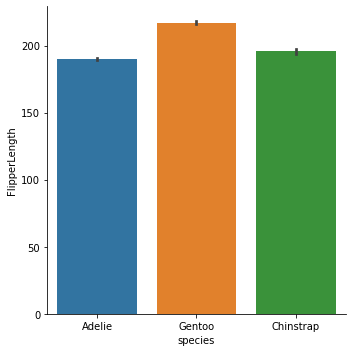

In [19]:
sns.catplot('species', 'FlipperLength', data=penguins, kind='bar')

## Testing

Let's do a *t*-test for whether the chinstrap and adelie have different flipper lengths.  The `ttest_ind` function does a two-sample T-test:

In [20]:
sps.ttest_ind(adelies['FlipperLength'], chinstraps['FlipperLength'], nan_policy='omit', equal_var=False)

Ttest_indResult(statistic=-5.780384584564813, pvalue=6.049266635901861e-08)

$p < 0.05$, that's for sure!  The probability of observing mean flipper lengths this different if there is no actual difference is quite low.

Let's try the bill depth:

In [21]:
sps.ttest_ind(adelies['BillDepth'], chinstraps['BillDepth'], nan_policy='omit')

Ttest_indResult(statistic=-0.4263555696052568, pvalue=0.670271404572444)

$p>0.05$. Very.  The evidence is not sufficient to reject the null hypothesis that Adelie and Chinstrap penguins have the same bill depth.

What about the bootstrap?  Remember that to do the bootstrap, we need to resample from the *pool* of measurements, because the procedure is to take bootstrap samples **from the distribution under the null hypothesis**, which is that there is no difference between penguins.

Let's go:

In [22]:
def boot_ind(s1, s2, nboot=10000):
    ## we will ignore NAs here
    obs1 = s1.dropna()
    obs2 = s2.dropna()
    n1 = len(obs1)
    n2 = len(obs2)
    
    ## pool the observations together
    pool = pd.concat([obs1, obs2])
    ## grab the observed mean
    md = np.mean(s1) - np.mean(s2)
    
    ## compute our bootstrap samples of the mean under H0
    b1 = np.array([np.mean(rng.choice(pool, size=n1)) for i in range(nboot)])
    b2 = np.array([np.mean(rng.choice(pool, size=n2)) for i in range(nboot)])
    
    ## the P-value is the probability that we observe a difference as large
    ## as we did in the raw data, if the null hypothesis were true
    return md, np.mean(np.abs(b1 - b2) >= np.abs(md))

And with this function, we can compute the bootstrap versions of the tests above:

In [23]:
boot_ind(adelies['FlipperLength'], chinstraps['FlipperLength'])

(-5.869887027658734, 0.0)

The $p$-value was very small in the $t$-test; it makes sense that we would almost never actually see a mean this large under the null!

Let's do the bill depth:

In [24]:
boot_ind(adelies['BillDepth'], chinstraps['BillDepth'])

(-0.07423061940008324, 0.6635)

Yeah, those kinds penguins probably have the same bill depth.

## Conclusion

We see extremely similar $p$-values and confidence intervals for the parameteric methods and the bootstrap.  That is expected — if two procedures that claimed to do the same thing returned wildly different results, we would have a problem.

But as we discussed in the videos, the bootstrap works in places where the parametrics won't.